In [1]:
import torch
import math
import matplotlib.pyplot as plt
from functools import partial

In [2]:
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

# K-means
This implement of k-means is a home work of [fastai course part2](https://course.fast.ai/Lessons/part2.html).

# Create Data

In [3]:
n_clusters = 6
n_samples = 250

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35

In [5]:
centroids

tensor([[ -3.628,  18.403],
        [ -7.049,  -8.394],
        [ 14.369,   2.944],
        [ 22.497, -17.995],
        [-24.635,  33.245],
        [ 13.786,  12.422]])

In [6]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [7]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([30.,30.]))).sample((n_samples,))

In [8]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [9]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

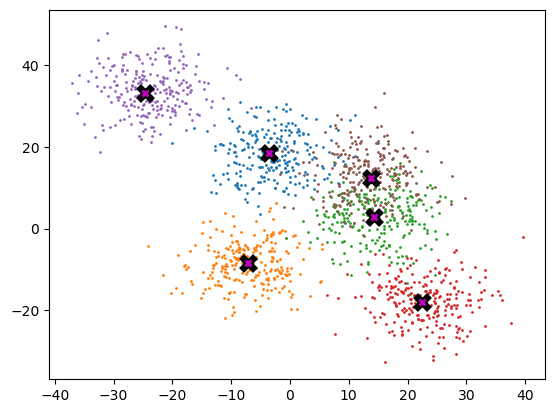

In [10]:
plot_data(centroids, data, 250)

# k-means

In [11]:
X = data.clone()

## Init mean

In [12]:
k = 6

In [13]:
perm = torch.randperm(X.size(0))

In [14]:
idx = perm[:k]
means = X[idx].clone()
means

tensor([[ 13.227,  -8.303],
        [ 11.784,  11.362],
        [ 15.491,  -4.326],
        [ 12.847, -19.425],
        [ 15.780,  17.934],
        [ -2.511,  -3.635]])

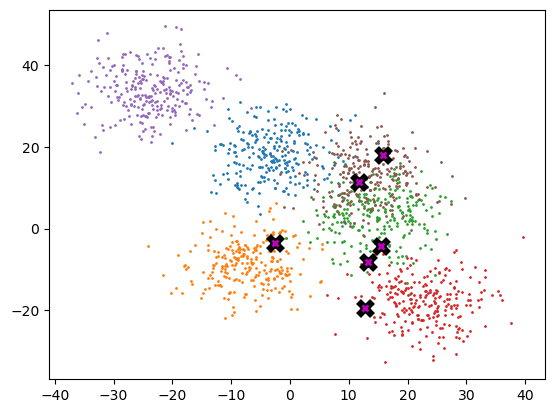

In [15]:
plot_data(means, X, 250)

## Calculate distance

In [16]:
means.shape, X.shape

(torch.Size([6, 2]), torch.Size([1500, 2]))

In [17]:
means[:, None].shape, X[None].shape

(torch.Size([6, 1, 2]), torch.Size([1, 1500, 2]))

In [18]:
(means[:, None] - X[None]).shape

torch.Size([6, 1500, 2])

In [19]:
mm = means[:, None] - X[None]

In [20]:
l2 = torch.einsum('ijk, ijk->ij', mm, mm)

In [21]:
l2

tensor([[ 734.640,  709.354,  706.383,  ...,  569.188, 1460.258, 1255.919],
        [ 297.342,  241.198,  183.035,  ...,   60.147,  350.148,  249.417],
        [ 684.036,  643.628,  618.255,  ...,  380.736, 1172.179, 1018.224],
        [1281.019, 1277.346, 1310.853,  ..., 1213.889, 2434.660, 2157.942],
        [ 494.725,  412.703,  316.399,  ...,   17.422,  144.967,  130.433],
        [ 232.653,  253.557,  305.201,  ...,  793.216, 1409.568, 1052.514]])

In [22]:
l2.shape

torch.Size([6, 1500])

In [23]:
(mm * mm).sum(2)

tensor([[ 734.640,  709.354,  706.383,  ...,  569.188, 1460.258, 1255.919],
        [ 297.342,  241.198,  183.035,  ...,   60.147,  350.148,  249.417],
        [ 684.036,  643.628,  618.255,  ...,  380.736, 1172.179, 1018.224],
        [1281.019, 1277.346, 1310.853,  ..., 1213.889, 2434.660, 2157.942],
        [ 494.725,  412.703,  316.399,  ...,   17.422,  144.967,  130.433],
        [ 232.653,  253.557,  305.201,  ...,  793.216, 1409.568, 1052.514]])

In [24]:
(mm * mm).sum(2).shape

torch.Size([6, 1500])

## Select nearest group

In [25]:
group = torch.argmin(l2, dim=0)

In [26]:
group.shape

torch.Size([1500])

## Update mean

In [27]:
X[group == 0].shape

torch.Size([47, 2])

In [28]:
torch.mean(X, 0)

tensor([2.815, 6.901])

In [29]:
for i in range(k):
    means[i] = torch.mean(X[group == i], 0)

In [30]:
means

tensor([[ 15.741, -10.534],
        [  0.595,  16.672],
        [ 18.710,  -2.103],
        [ 22.234, -19.903],
        [  2.595,  25.472],
        [-11.656,   2.780]])

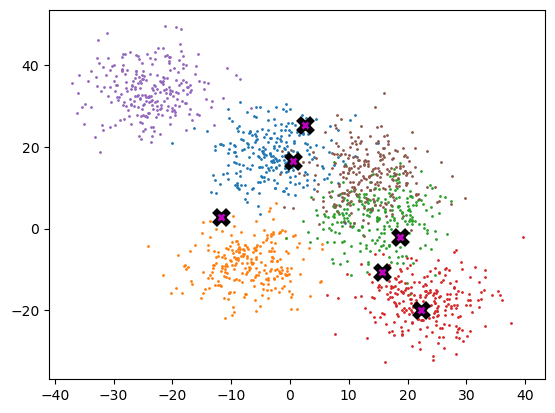

In [31]:
plot_data(means, data, 250)

## Write update loop

In [32]:
def update(means, X, n):
    for t in range(n):
        mm = means[:, None] - X[None]
        l2 = torch.einsum('ijk, ijk->ij', mm, mm)
        group = torch.argmin(l2, dim=0)
        for i in range(k):
            means[i] = torch.mean(X[group == i], 0)

In [33]:
update(means, X, 10)

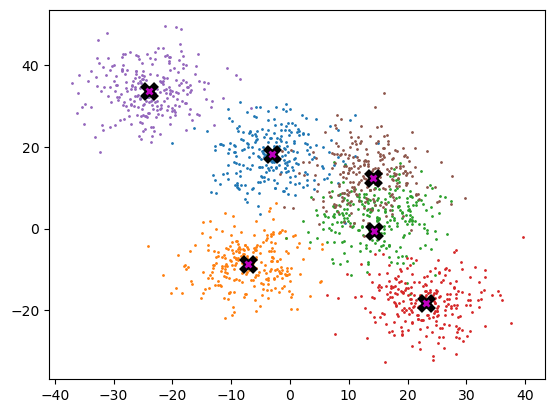

In [34]:
plot_data(means, data, 250)

## Write k-means function

In [35]:
def kmeans(X, k, n):
    # init means
    perm = torch.randperm(X.size(0))
    idx = perm[:k]
    means = X[idx].clone()

    for t in range(n):
        mm = means[:, None] - X[None]
        l2 = torch.einsum('ijk, ijk->ij', mm, mm)
        group = torch.argmin(l2, dim=0)
        for i in range(k):
            means[i] = torch.mean(X[group == i], 0)
    
    return means

In [36]:
means = kmeans(X, 6, 10)

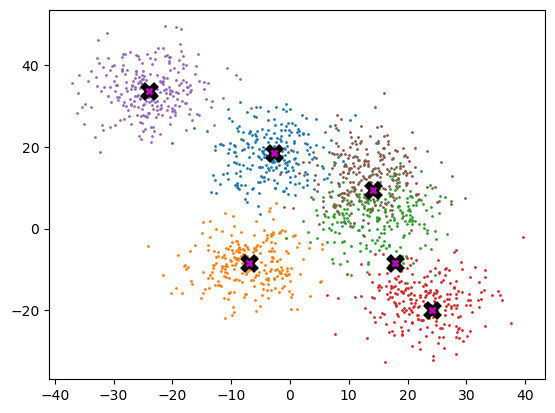

In [37]:
plot_data(means, data, 250)

# Animation

In [38]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [39]:
def init_means(X, k):
    perm = torch.randperm(X.size(0))
    idx = perm[:k]
    means = X[idx].clone()
    return means

In [40]:
def one_update(X, means, k):
    mm = means[:, None] - X[None]
    l2 = torch.einsum('ijk, ijk->ij', mm, mm)
    group = torch.argmin(l2, dim=0)
    for i in range(k):
        means[i] = torch.mean(X[group == i], 0)
    return group

In [41]:
def plot_data_group(centroids, group, data, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[group == i]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

In [42]:
def do_one(d, means, k):
    pre_means = means.clone()
    group = one_update(X, means, k)
    ax.clear()
    plot_data_group(pre_means, group, X, ax=ax)

In [43]:
X = data.clone()
k = 5
fig,ax = plt.subplots()
means = init_means(X, k)
f1 = partial(do_one, means=means, k=k)
ani = FuncAnimation(fig, f1, frames=10, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())